# Downloading the Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -qq /content/gdrive/MyDrive/jena_climate_2009_2016.zip

Mounted at /content/gdrive


# Basic machine learning model example

**Inspecting the dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


**Parsing the dataset**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

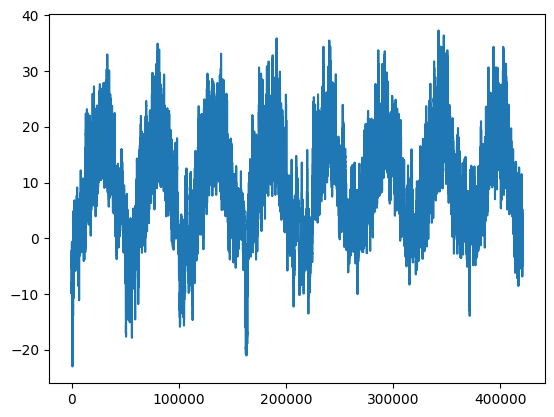

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

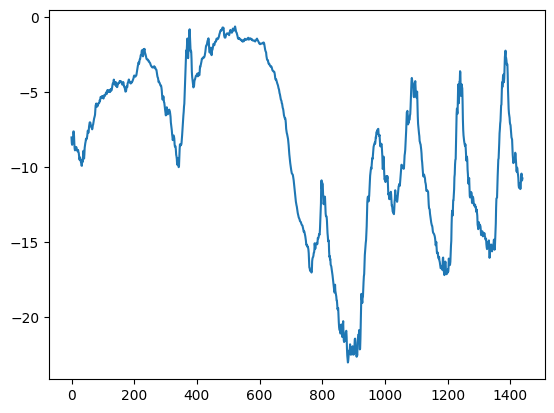

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210275
num_val_samples: 105137
num_test_samples: 105139


**Preparing the data**

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/15
819/819 [==============================] - 12s 13ms/step - loss: 13.5277 - mae: 2.8421 - val_loss: 11.0558 - val_mae: 2.6321
Epoch 2/15
819/819 [==============================] - 11s 13ms/step - loss: 9.6886 - mae: 2.4453 - val_loss: 10.9619 - val_mae: 2.6200
Epoch 3/15
819/819 [==============================] - 11s 13ms/step - loss: 8.8170 - mae: 2.3346 - val_loss: 10.5536 - val_mae: 2.5705
Epoch 4/15
819/819 [==============================] - 11s 13ms/step - loss: 8.1475 - mae: 2.2455 - val_loss: 10.0161 - val_mae: 2.5024
Epoch 5/15
819/819 [==============================] - 11s 13ms/step - loss: 7.7479 - mae: 2.1916 - val_loss: 14.7316 - val_mae: 3.0549
Epoch 6/15
819/819 [==============================] - 11s 13ms/step - loss: 7.4201 - mae: 2.1455 - val_loss: 10.1386 - val_mae: 2.5113
Epoch 7/15
819/819 [==============================] - 11s 13ms/step - loss: 7.1709 - mae: 2.1114 - val_loss: 12.1913 - val_mae: 2.7610
Epoch 8/15
819/819 [==============================] - 

**Plotting the results**

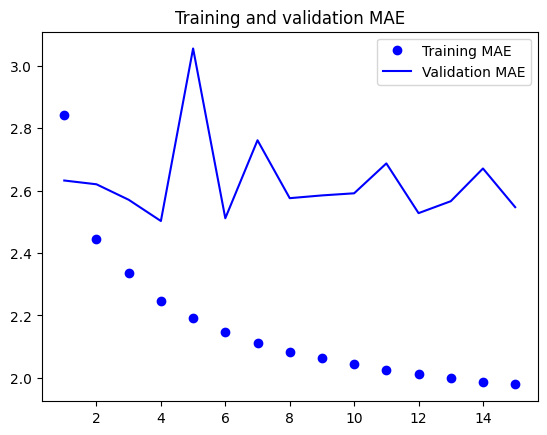

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Trying timeseries data with LSTM layering

In [14]:
from tensorflow.keras.layers import LSTM, Dropout

**Defining the model architecture with LSTM and dropout**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

**Create and trian the model**

In [16]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 19s 18ms/step - loss: 17.5695 - mae: 3.0553 - val_loss: 10.8218 - val_mae: 2.5801
Epoch 2/15
819/819 [==============================] - 15s 19ms/step - loss: 7.4791 - mae: 2.1204 - val_loss: 12.1848 - val_mae: 2.7319
Epoch 3/15
819/819 [==============================] - 16s 19ms/step - loss: 5.0866 - mae: 1.7405 - val_loss: 12.9395 - val_mae: 2.8063
Epoch 4/15
819/819 [==============================] - 15s 18ms/step - loss: 3.8539 - mae: 1.5149 - val_loss: 13.8466 - val_mae: 2.9255
Epoch 5/15
819/819 [==============================] - 15s 18ms/step - loss: 3.2509 - mae: 1.3883 - val_loss: 13.8450 - val_mae: 2.9176
Epoch 6/15
819/819 [==============================] - 15s 18ms/step - loss: 2.8574 - mae: 1.2993 - val_loss: 13.7963 - val_mae: 2.9036
Epoch 7/15
819/819 [==============================] - 15s 18ms/step - loss: 2.6615 - mae: 1.2513 - val_loss: 13.9856 - val_mae: 2.9303
Epoch 8/15
819/819 [==============================] - 

**Evaluating the model**

In [18]:
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 15.4686 - mae: 3.1200
Test MAE: 3.12


**Plotting the results**

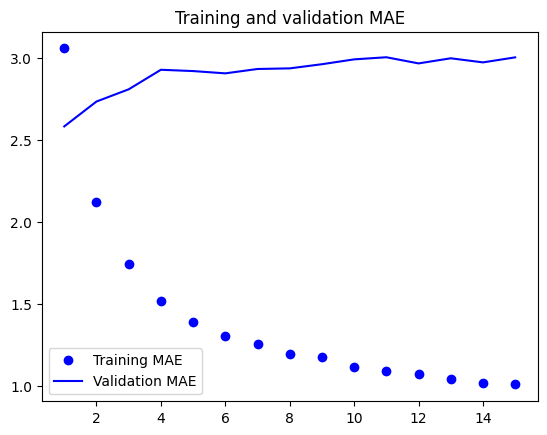

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Using a combination of 1d_convnets & RNN

In [20]:
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

**Defining the model architecture with 1D convnets**

In [21]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu', input_shape=(sequence_length, raw_data.shape[-1])))
model.add(Conv1D(64, 5, activation='relu'))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

**Compile the model**

In [22]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

**Train the model**

In [23]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 235s 281ms/step - loss: 16.2991 - mae: 2.9564 - val_loss: 9.6344 - val_mae: 2.3955
Epoch 2/15
819/819 [==============================] - 228s 279ms/step - loss: 7.9609 - mae: 2.1966 - val_loss: 9.8910 - val_mae: 2.4515
Epoch 3/15
819/819 [==============================] - 226s 275ms/step - loss: 6.1291 - mae: 1.9162 - val_loss: 10.9939 - val_mae: 2.5868
Epoch 4/15
819/819 [==============================] - 227s 277ms/step - loss: 4.8233 - mae: 1.6906 - val_loss: 11.8565 - val_mae: 2.7088
Epoch 5/15
819/819 [==============================] - 229s 279ms/step - loss: 3.8821 - mae: 1.5127 - val_loss: 12.4706 - val_mae: 2.7789
Epoch 6/15
819/819 [==============================] - 228s 278ms/step - loss: 3.2702 - mae: 1.3900 - val_loss: 12.9060 - val_mae: 2.8217
Epoch 7/15
819/819 [==============================] - 231s 281ms/step - loss: 2.9037 - mae: 1.3090 - val_loss: 13.2490 - val_mae: 2.8575
Epoch 8/15
819/819 [======================

**Evaluating the model**

In [24]:
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

405/405 [==============================] - 14s 34ms/step - loss: 15.3737 - mae: 3.1133
Test MAE: 3.11


**Plotting the results**

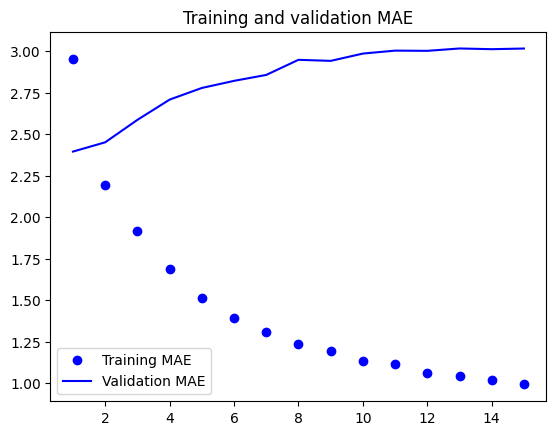

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Adjusting the number of units in each recurrent layer

In [26]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

**Define model architecture**

In [27]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

**Compile the model**

In [28]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

**Train the model**

In [29]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/15
819/819 [==============================] - 19s 19ms/step - loss: 16.1775 - mae: 3.0249 - val_loss: 9.8786 - val_mae: 2.4347
Epoch 2/15
819/819 [==============================] - 15s 19ms/step - loss: 8.1679 - mae: 2.2380 - val_loss: 11.7606 - val_mae: 2.6885
Epoch 3/15
819/819 [==============================] - 16s 19ms/step - loss: 5.6320 - mae: 1.8400 - val_loss: 13.4830 - val_mae: 2.9098
Epoch 4/15
819/819 [==============================] - 15s 19ms/step - loss: 3.7851 - mae: 1.5008 - val_loss: 14.2912 - val_mae: 3.0024
Epoch 5/15
819/819 [==============================] - 16s 19ms/step - loss: 2.8523 - mae: 1.2974 - val_loss: 14.3236 - val_mae: 2.9916
Epoch 6/15
819/819 [==============================] - 16s 19ms/step - loss: 2.4165 - mae: 1.1903 - val_loss: 14.5370 - val_mae: 3.0084
Epoch 7/15
819/819 [==============================] - 16s 19ms/step - loss: 2.1698 - mae: 1.1228 - val_loss: 14.2328 - val_mae: 2.9680
Epoch 8/15
819/819 [==============================] - 1

**Evaluate the model**

In [30]:
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

405/405 [==============================] - 4s 9ms/step - loss: 15.0211 - mae: 3.0818
Test MAE: 3.08


**Plot the results**

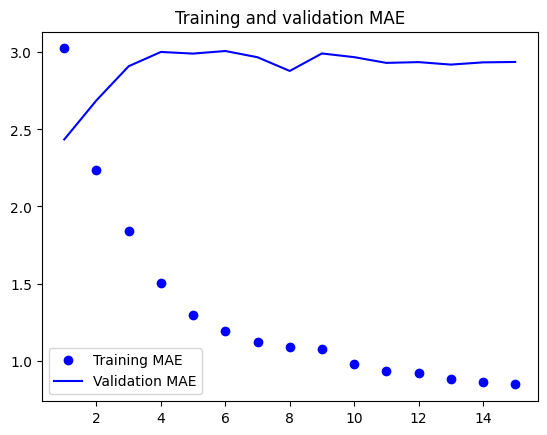

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()